# GeoML with EuroSAT Notebook
In this notebook, we download and visualize EuroSAT data from both the spatial and non-spatial splits. We then train two ResNet50 image encoders on each dataset, one with randomly initialized weights and one with pre-initialized weights from SSL4EO-S12. We then evaluate each on the test and train data, and then customize the training.  

In [1]:
# data libraries
import os
from torch.utils.data import DataLoader
from torchgeo.datasets import EuroSAT, EuroSATSpatial
import random
import matplotlib.pyplot as plt

# ml libraries
import torch # for model training
from torch import nn # for neural network layers
from torch.utils.data import RandomSampler
from torch.utils.data import DataLoader
from torchvision.transforms import v2 as transforms
from torchgeo.models import resnet50 # import resnet50 model from torchvision
from torchgeo.models import ResNet50_Weights

/home/isly9493/miniconda3/envs/pyt2/lib/python3.11/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
/home/isly9493/miniconda3/envs/pyt2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Download and Visualize EuroSat Data

In this section, we use the torchgeo dataset/datamodules to download the EuroSat dataset (spatial and nonspatial split versions). We then plot a random sample of 6 images (with labels) from the training set and the test set for each dataset version. We also calculate the number of samples in each split for each version (spatial and nonspatial).

### EuroSAT

In [2]:
eurosat_root = os.path.join("data", "eurosat")
eurosat_dataset_train = EuroSAT(eurosat_root, split="train", download=True)
eurosat_dataset_test = EuroSAT(eurosat_root, split="test", download=True)

print(f'Dataset Classes: {eurosat_dataset_train.classes}')
print(f'Number of images in train dataset: {len(eurosat_dataset_train)}')
print(f'Number of images in test dataset: {len(eurosat_dataset_test)}')

Dataset Classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Number of images in train dataset: 16200
Number of images in test dataset: 5400


### EuroSAT Spatial

In [3]:
eurosat_spatial_root = os.path.join("data", "eurosatSpatial")
eurosat_spatial_dataset_train = EuroSATSpatial(eurosat_spatial_root, split="train", download=True)
eurosat_spatial_dataset_test = EuroSATSpatial(eurosat_spatial_root, split="test", download=True)

print(f'Dataset Classes: {eurosat_spatial_dataset_train.classes}')
print(f'Number of images in train dataset: {len(eurosat_spatial_dataset_train)}')
print(f'Number of images in test dataset: {len(eurosat_spatial_dataset_test)}')

Dataset Classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Number of images in train dataset: 16200
Number of images in test dataset: 5400


### # of Images in Each Dataset Split
Split    | %            | EuroSAT   | EuroSAT Spatial   |
---------|-----------   |---------  |---------          |
Train    |  60          |   16200   |   16200           |
Validate |  20          |   5400    |   5400            |
Test     |  20          |   5400    |   5400            |

### Visualize Images and Labels from Each Dataset

In [4]:
# set seed for reproducibility
random.seed(44)

eurosat_datasets = {
    "eurosat_train": eurosat_dataset_train,
    "eurosat_test": eurosat_dataset_test,
    "eurosat_spatial_train": eurosat_spatial_dataset_train,
    "eurosat_spatial_test": eurosat_spatial_dataset_test
}
figures_base_path = os.path.join("figures", "eurosat100")


# sample 6 random images, plot, and export the figures
for name, dataset in eurosat_datasets.items():
    n = 0
    for i in random.sample(range(len(dataset)), 6):
        fig = dataset.plot(
            sample=dataset.__getitem__(i),
            show_titles=True
        )
        # export fig to png
        path = os.path.join("figures", "eurosat", f"{name}_{n}.png")
        fig.savefig(path)
        plt.close(fig)
        n += 1

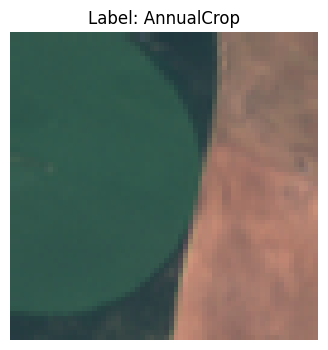

In [5]:
# visualize just one image
fig = eurosat_dataset_train.plot(
    sample=eurosat_dataset_train.__getitem__(1),
    show_titles=True
)

## 2. Train & Evaluate a Model on the EuroSAT Data 

In this section, we train two ResNet 50 models on the nonspatial EuroSat dataset: one with randomly initialized weights, and one with pre-initialized weights from the SSL4EO-S12 project (use the pretrained weights available in torchgeo). We report the performance of these models on the train and test sets in a table. In addition to the table, we report (i) how we implemented the training and evaluation procedure, what hyperparameters we use to train the model, and how we choose those hyperparameters (e.g. if we perform a cross-validation search for hyperparameters, we explain how you conducted that search), (ii) what pretrained weights we choose to use, and a short description of the process used to generate those weights, (iii) a short paragraph describing the results in your table in words.

The flow of this section is as follows:
1. Configure the GPU
1. Define the Train and Test Loos
1. Define a ResNet model with random weights, customize the model for EuroSat data
1. Define a data sampler and loader
1. Load and transform the data
1. Train & evaluate the model
1. Repeat with a pre-trained ResNet50
1. Report results

#### Configure GPU

Note: there are additional steps required on Mac to use your processor as a GPU.

In [2]:
# set seed for reproducibility
torch.manual_seed(44)

# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


#### Define the Train & Test Loops

In [3]:
# train loop
# from the pytorch tutorial
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, sample in enumerate(dataloader):
        X, y = sample['image'], sample['label']
        X, y = X.to(device), y.to(device)
        
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # print intermediate results every n batches
        n = 20
        if batch % n == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [4]:
# test loop
# from the pytorch tutorial
def test(dataloader, model, loss_fn, val=False):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for sample in dataloader:
            X, y = sample['image'], sample['label']
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    prefix = "Validation" if val else "Test"
    print(f"{prefix} Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

#### Define the Dataloaders

In [5]:
def load_eurosat_data(txs, batch_size=64):
    # todo: reimplement with a for loop over train, val, and test
    # reload data with the new transform
    root = os.path.join("data", "eurosat")
    dataset_train = EuroSAT(root, split="train", download=True, transforms=txs)
    dataset_val = EuroSAT(root, split="val", download=True, transforms=txs)
    dataset_test = EuroSAT(root, split="test", download=True, transforms=txs)

    # define a sampler for the EuroSAT dataset
    # it's a non-spatial dataset, so we can use a regular sampler from pytorch
    sampler_train = RandomSampler(dataset_train, replacement=False) # start with a small batch
    sampler_val = RandomSampler(dataset_val, replacement=False) # start with a small batch
    sampler_test = RandomSampler(dataset_test, replacement=False) # start with a small batch

    # define a dataloader to iterate over the dataset
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, sampler=sampler_train)
    dataloader_val = DataLoader(dataset_val, batch_size=batch_size, sampler=sampler_val)
    dataloader_test = DataLoader(dataset_test, batch_size=batch_size, sampler=sampler_test)
    
    return dataloader_train, dataloader_val, dataloader_test

#### Define Data Transforms

In [6]:
# Custom transform function to handle the dictionary structure of torchgeo dataset
class CustomTransform:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, sample):
        sample['image'] = self.transform(sample['image'])
        return sample
    
# Define transformations for the dataset to get it from 64x64 to 224x224
transform = transforms.Resize((224, 224))  # Resizes the images to 224x224

custom_transform = CustomTransform(transform)

#### Define Train, Val, Test Function

In [7]:
def train_val_test(dataloader_train, dataloader_val, dataloader_test, model, loss_fn=nn.CrossEntropyLoss(), lr=1e-3, epochs=5):
    # create optimizer from the model and the learning rate
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    
    # baseline before training
    print(f"Baseline Before Training\n-------------------------------")
    test(dataloader_test, model, loss_fn, val=False)
    test(dataloader_val, model, loss_fn, val=True)

    # run train / val loop
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train(dataloader_train, model, loss_fn, optimizer)
        test(dataloader_val, model, loss_fn, val=True)

    # test result with test data
    print("Test Results\n-------------------------------")
    test(dataloader_test, model, loss_fn, val=False)

    print("Training Complete!")

def evaluate_model(model, dataloader_test, loss_fn=nn.CrossEntropyLoss()):
    print(f"Evaluating Model on Test Data\n-------------------------------")
    test(dataloader_test, model, loss_fn, val=False)

#### Define a Function to Save Down the Model

In [8]:
def save_model(model, experiment_name):
    if not os.path.exists("models"):
        os.makedirs("models")
    model_weights_path = os.path.join("models", "eurosat", experiment_name)
    torch.save(model.state_dict(), model_weights_path)

#### Define the Model

In [9]:
model = resnet50(weights=None).to(device)

# modify the ResNet model to have 10 output classes
model.fc = nn.Linear(2048, 10).to(device)

# modify the model to expect 13 channels instead of 3
model.conv1 = nn.Conv2d(13, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False).to(device)

#### Load the EuroSAT Data

In [13]:
dataloader_train, dataloader_val, dataloader_test = load_eurosat_data(custom_transform, batch_size=64)

#### Train & Test the Model

In [ ]:
train_val_test(dataloader_train, dataloader_val, dataloader_test, model, lr=1e-3, epochs=1)

#### Save the Current Model

In [ ]:
save_model(model, "eurosat_resnet50_epochs10.pth")

#### Redefine Model with Pre-Trained Weights

In [48]:
model = resnet50(weights=ResNet50_Weights.SENTINEL2_ALL_MOCO).to(device) # note the model with these weights is 90.1MB
# this version already expects 13 input channels
# modify the ResNet model to have 10 output classes
model.fc = nn.Linear(2048, 10).to(device)

#### Reload EuroSAT Data

In [49]:
dataloader_train, dataloader_val, dataloader_test = load_eurosat_data(custom_transform, batch_size=64)

#### Retrain & Retest the Model

In [53]:
train_val_test(dataloader_train, dataloader_val, dataloader_test, model, lr=1e-3, epochs=5)

Baseline Before Training
-------------------------------
Test Error: 
 Accuracy: 67.6%, Avg loss: 2.090453 

Validation Error: 
 Accuracy: 67.0%, Avg loss: 2.100065 

Epoch 1
-------------------------------
loss: 2.079106  [   64/16200]
loss: 2.088745  [ 1344/16200]
loss: 2.077664  [ 2624/16200]
loss: 2.083632  [ 3904/16200]
loss: 2.108026  [ 5184/16200]
loss: 2.062145  [ 6464/16200]
loss: 2.069866  [ 7744/16200]
loss: 2.087678  [ 9024/16200]
loss: 2.027572  [10304/16200]
loss: 2.021021  [11584/16200]
loss: 2.081037  [12864/16200]
loss: 2.003981  [14144/16200]
loss: 2.100436  [15424/16200]
Validation Error: 
 Accuracy: 71.1%, Avg loss: 2.022634 

Epoch 2
-------------------------------
loss: 1.991411  [   64/16200]
loss: 2.106288  [ 1344/16200]
loss: 2.026760  [ 2624/16200]
loss: 2.028827  [ 3904/16200]
loss: 2.086024  [ 5184/16200]
loss: 2.029194  [ 6464/16200]
loss: 1.992813  [ 7744/16200]
loss: 1.962950  [ 9024/16200]
loss: 1.977433  [10304/16200]
loss: 1.982259  [11584/16200]
loss:

#### Save Down the Fine-Tuned Pre-Trained Model

In [52]:
save_model(model, "eurosat_resnet50_pretrained_epochs5_v2.pth")

## 3. Train & Evaluate a Model on the EuroSAT Spatial Data

#### Define EuroSAT Spatial Dataloader

In [9]:
def load_eurosat_spatial_data(txs, batch_size=64):
    # reload data with the new transform
    root = os.path.join("data", "eurosatSpatial")
    dataset_train = EuroSATSpatial(root, split="train", download=True, transforms=txs)
    dataset_val = EuroSATSpatial(root, split="val", download=True, transforms=txs)
    dataset_test = EuroSATSpatial(root, split="test", download=True, transforms=txs)

    # define a sampler for the EuroSATSpatial dataset
    # it's a non-spatial dataset, so we can use a regular sampler from pytorch
    sampler_train = RandomSampler(dataset_train, replacement=False) # start with a small batch
    sampler_val = RandomSampler(dataset_val, replacement=False) # start with a small batch
    sampler_test = RandomSampler(dataset_test, replacement=False) # start with a small batch

    # define a dataloader to iterate over the dataset
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, sampler=sampler_train)
    dataloader_val = DataLoader(dataset_val, batch_size=batch_size, sampler=sampler_val)
    dataloader_test = DataLoader(dataset_test, batch_size=batch_size, sampler=sampler_test)

    return dataloader_train, dataloader_val, dataloader_test

#### Define the Model

In [16]:
model = resnet50(weights=None).to(device)

# modify the ResNet model to have 10 output classes
model.fc = nn.Linear(2048, 10).to(device)

# modify the model to expect 13 channels instead of 3
model.conv1 = nn.Conv2d(13, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False).to(device)

#### Load the EuroSAT Spatial Data

In [17]:
dataloader_train, dataloader_val, dataloader_test = load_eurosat_spatial_data(custom_transform, batch_size=64)

#### Train & Test the Model

In [ ]:
train_val_test(dataloader_train, dataloader_val, dataloader_test, model, lr=1e-3, epochs=5)

#### Save Down the Model

In [33]:
save_model(model, "eurosatspatial_resnet50_epochs10.pth")

#### Redefine the Model

In [21]:
model = resnet50(weights=ResNet50_Weights.SENTINEL2_ALL_MOCO).to(device) # note the model with these weights is 90.1MB

# modify the ResNet model to have 10 output classes
model.fc = nn.Linear(2048, 10).to(device)

#### Reload EuroSAT Spatial Data

In [22]:
dataloader_train, dataloader_val, dataloader_test = load_eurosat_spatial_data(custom_transform, batch_size=64)

#### Retrain & Retest the Model

In [ ]:
train_val_test(dataloader_train, dataloader_val, dataloader_test, model, lr=1e-3, epochs=10)

#### Save Down the Fine-Tuned Pre-Trained Model

In [13]:
save_model(model, "eurosatspatial_resnet50_pretrained_epochs10.pth")

#### Load and Evaluate a Given Model

In [12]:
def load_model(experiment_name):
    # create an empty res net with the right io dimensions
    model = resnet50(weights=None, in_chans=13, num_classes=10).to(device)
    # create the path to the model weights
    model_weights_path = os.path.join("models", "eurosat", experiment_name)
    # load the model weights from the path
    model.load_state_dict(torch.load(model_weights_path))
    return model

In [47]:
experiment_name = "eurosat_resnet50_pretrained_epochs10.pth"
model = load_model(experiment_name)
_, _, dataloader_test = load_eurosat_data(batch_size=64)
evaluate_model(model, dataloader_test)

/tmp/ipykernel_1681832/3585238199.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_weights_path))


Evaluating Model on Test Data
-------------------------------
Test Error: 
 Accuracy: 74.4%, Avg loss: 1.810232 



## 4. Add in Data Augmentation Techniques
This section adds in additonal data transforms prior to loading the data that flip, rotate, noise, etc the data prior to training to create more samples. We then rerun some of the top-performing experiments to see how the results change. 

#### Define a New Custom Transform

In [10]:
# Define transformations for the dataset to get it from 64x64 to 224x224
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip the image horizontally
    transforms.RandomVerticalFlip(p=0.5),  # Randomly flip the image vertically
    transforms.Resize((224, 224))  # Resizes the images to 224x224
])

custom_transform = CustomTransform(transform)

#### Redo Training for Each Model

In [12]:
# model = resnet50(weights=None, in_chans=13, num_classes=10).to(device)
model = load_model("eurosat_resnet50_imgflips_epochs5.pth")
dataloader_train, dataloader_val, dataloader_test = load_eurosat_data(custom_transform, batch_size=64)
train_val_test(dataloader_train, dataloader_val, dataloader_test, model, lr=1e-3, epochs=5)
save_model(model, "eurosat_resnet50_imgflips_epochs10.pth")

/tmp/ipykernel_2603663/2779468065.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_weights_path))


Baseline Before Training
-------------------------------
Test Error: 
 Accuracy: 76.2%, Avg loss: 0.803481 

Validation Error: 
 Accuracy: 75.6%, Avg loss: 0.823417 

Epoch 1
-------------------------------
loss: 0.804927  [   64/16200]
loss: 0.624438  [ 1344/16200]
loss: 0.825412  [ 2624/16200]
loss: 0.691295  [ 3904/16200]
loss: 0.845601  [ 5184/16200]
loss: 0.705668  [ 6464/16200]
loss: 0.950877  [ 7744/16200]
loss: 0.561642  [ 9024/16200]
loss: 0.719170  [10304/16200]
loss: 0.579537  [11584/16200]
loss: 0.665559  [12864/16200]
loss: 0.887553  [14144/16200]
loss: 0.731226  [15424/16200]
Validation Error: 
 Accuracy: 74.5%, Avg loss: 0.779164 

Epoch 2
-------------------------------
loss: 0.670644  [   64/16200]
loss: 0.753823  [ 1344/16200]
loss: 0.662568  [ 2624/16200]
loss: 0.834877  [ 3904/16200]
loss: 0.806893  [ 5184/16200]
loss: 0.526802  [ 6464/16200]
loss: 0.691623  [ 7744/16200]
loss: 0.593660  [ 9024/16200]
loss: 0.665421  [10304/16200]
loss: 0.803039  [11584/16200]
loss:

In [18]:
# model = resnet50(weights=ResNet50_Weights.SENTINEL2_ALL_MOCO, in_chans=13, num_classes=10).to(device) 
model = load_model("eurosat_resnet50_pretrained_imgflips_epochs5.pth")
dataloader_train, dataloader_val, dataloader_test = load_eurosat_data(custom_transform, batch_size=64)
train_val_test(dataloader_train, dataloader_val, dataloader_test, model, lr=1e-3, epochs=5)
save_model(model, "eurosat_resnet50_pretrained_imgflips_epochs10.pth")

/tmp/ipykernel_2603663/2779468065.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_weights_path))


Baseline Before Training
-------------------------------
Test Error: 
 Accuracy: 80.1%, Avg loss: 2.066019 



Validation Error: 
 Accuracy: 80.2%, Avg loss: 2.076467 

Epoch 1
-------------------------------
loss: 2.086790  [   64/16200]
loss: 2.080106  [ 1344/16200]
loss: 2.076344  [ 2624/16200]
loss: 2.082392  [ 3904/16200]
loss: 2.084616  [ 5184/16200]
loss: 2.072159  [ 6464/16200]
loss: 2.080302  [ 7744/16200]
loss: 2.045496  [ 9024/16200]
loss: 2.045351  [10304/16200]
loss: 2.035016  [11584/16200]
loss: 2.051425  [12864/16200]
loss: 1.990753  [14144/16200]
loss: 2.022725  [15424/16200]
Validation Error: 
 Accuracy: 80.4%, Avg loss: 2.025832 

Epoch 2
-------------------------------
loss: 1.980469  [   64/16200]
loss: 2.023612  [ 1344/16200]
loss: 2.044255  [ 2624/16200]
loss: 2.008262  [ 3904/16200]
loss: 2.000562  [ 5184/16200]
loss: 1.952807  [ 6464/16200]
loss: 2.004670  [ 7744/16200]
loss: 2.005918  [ 9024/16200]
loss: 2.044146  [10304/16200]
loss: 1.959069  [11584/16200]
loss: 2.021442  [12864/16200]
loss: 1.964187  [14144/16200]
loss: 1.967936  [15424/16200]
Validation Error: 
 Accu

In [19]:
# model = resnet50(weights=None, in_chans=13, num_classes=10).to(device)
model = load_model("eurosatspatial_resnet50_imgflips_epochs5.pth")
dataloader_train, dataloader_val, dataloader_test = load_eurosat_spatial_data(custom_transform, batch_size=64)
train_val_test(dataloader_train, dataloader_val, dataloader_test, model, lr=1e-3, epochs=5)
save_model(model, "eurosatspatial_resnet50_imgflips_epochs10.pth")

/tmp/ipykernel_2603663/2779468065.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_weights_path))


Baseline Before Training
-------------------------------
Test Error: 
 Accuracy: 50.3%, Avg loss: 1.486576 

Validation Error: 
 Accuracy: 58.9%, Avg loss: 1.146402 

Epoch 1
-------------------------------
loss: 0.694296  [   64/16200]
loss: 0.675779  [ 1344/16200]
loss: 0.709526  [ 2624/16200]
loss: 0.757847  [ 3904/16200]
loss: 0.592432  [ 5184/16200]
loss: 0.907699  [ 6464/16200]
loss: 0.629734  [ 7744/16200]
loss: 0.977323  [ 9024/16200]
loss: 0.597705  [10304/16200]
loss: 0.695707  [11584/16200]
loss: 0.632978  [12864/16200]
loss: 0.720215  [14144/16200]
loss: 0.732632  [15424/16200]
Validation Error: 
 Accuracy: 71.0%, Avg loss: 0.958194 

Epoch 2
-------------------------------
loss: 0.558906  [   64/16200]
loss: 0.663115  [ 1344/16200]
loss: 0.689020  [ 2624/16200]
loss: 0.614705  [ 3904/16200]
loss: 0.642183  [ 5184/16200]
loss: 0.618881  [ 6464/16200]
loss: 0.681600  [ 7744/16200]
loss: 0.660640  [ 9024/16200]
loss: 0.524645  [10304/16200]
loss: 0.679727  [11584/16200]
loss:

In [20]:
# model = resnet50(weights=ResNet50_Weights.SENTINEL2_ALL_MOCO, in_chans=13, num_classes=10).to(device) 
model = load_model("eurosatspatial_resnet50_imgflips_epochs5.pth")
dataloader_train, dataloader_val, dataloader_test = load_eurosat_spatial_data(custom_transform, batch_size=64)
train_val_test(dataloader_train, dataloader_val, dataloader_test, model, lr=1e-3, epochs=5)
save_model(model, "eurosatspatial_resnet50_pretrained_imgflips_epochs10.pth")

/tmp/ipykernel_2603663/2779468065.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_weights_path))


Baseline Before Training
-------------------------------
Test Error: 
 Accuracy: 50.2%, Avg loss: 1.485485 

Validation Error: 
 Accuracy: 58.9%, Avg loss: 1.146341 

Epoch 1
-------------------------------
loss: 0.910224  [   64/16200]
loss: 0.736308  [ 1344/16200]
loss: 0.660054  [ 2624/16200]
loss: 0.747586  [ 3904/16200]
loss: 0.629617  [ 5184/16200]
loss: 0.609183  [ 6464/16200]
loss: 0.656615  [ 7744/16200]
loss: 0.633227  [ 9024/16200]
loss: 0.803281  [10304/16200]
loss: 0.568209  [11584/16200]
loss: 0.685856  [12864/16200]
loss: 0.580444  [14144/16200]
loss: 0.822633  [15424/16200]
Validation Error: 
 Accuracy: 77.1%, Avg loss: 0.784715 

Epoch 2
-------------------------------
loss: 0.688224  [   64/16200]
loss: 0.733352  [ 1344/16200]
loss: 0.718779  [ 2624/16200]
loss: 0.679840  [ 3904/16200]
loss: 0.613732  [ 5184/16200]
loss: 0.651815  [ 6464/16200]
loss: 0.559885  [ 7744/16200]
loss: 0.508569  [ 9024/16200]
loss: 0.535761  [10304/16200]
loss: 0.556855  [11584/16200]
loss:

#### Try 20 Epochs 

In [15]:
# model = resnet50(weights=ResNet50_Weights.SENTINEL2_ALL_MOCO, in_chans=13, num_classes=10).to(device) 
model = load_model("eurosat_resnet50_pretrained_imgflips_epochs20.pth")
dataloader_train, dataloader_val, dataloader_test = load_eurosat_data(custom_transform, batch_size=64)
train_val_test(dataloader_train, dataloader_val, dataloader_test, model, lr=1e-3, epochs=10)
save_model(model, "eurosat_resnet50_pretrained_imgflips_epochs20.pth")

/tmp/ipykernel_2617155/2779468065.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_weights_path))


Baseline Before Training
-------------------------------
Test Error: 
 Accuracy: 78.9%, Avg loss: 1.187338 

Validation Error: 
 Accuracy: 78.7%, Avg loss: 1.195844 

Epoch 1
-------------------------------
loss: 1.228060  [   64/16200]
loss: 1.183465  [ 1344/16200]
loss: 1.162653  [ 2624/16200]
loss: 1.152022  [ 3904/16200]
loss: 1.094136  [ 5184/16200]
loss: 1.092738  [ 6464/16200]
loss: 1.157012  [ 7744/16200]
loss: 1.193702  [ 9024/16200]
loss: 1.300223  [10304/16200]
loss: 1.100065  [11584/16200]
loss: 1.094736  [12864/16200]
loss: 1.070426  [14144/16200]
loss: 1.009488  [15424/16200]
Validation Error: 
 Accuracy: 79.9%, Avg loss: 1.052485 

Epoch 2
-------------------------------
loss: 1.039404  [   64/16200]
loss: 1.021817  [ 1344/16200]
loss: 1.087801  [ 2624/16200]
loss: 1.126137  [ 3904/16200]
loss: 1.035544  [ 5184/16200]
loss: 1.073685  [ 6464/16200]
loss: 1.156154  [ 7744/16200]
loss: 1.178079  [ 9024/16200]
loss: 0.954359  [10304/16200]
loss: 1.011315  [11584/16200]
loss:

In [13]:
# model = resnet50(weights=ResNet50_Weights.SENTINEL2_ALL_MOCO, in_chans=13, num_classes=10).to(device) 
model = load_model("eurosatspatial_resnet50_imgflips_epochs10.pth")
dataloader_train, dataloader_val, dataloader_test = load_eurosat_spatial_data(custom_transform, batch_size=64)
train_val_test(dataloader_train, dataloader_val, dataloader_test, model, lr=1e-3, epochs=10)
save_model(model, "eurosatspatial_resnet50_pretrained_imgflips_epochs20.pth")

/tmp/ipykernel_2617155/2779468065.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_weights_path))


Baseline Before Training
-------------------------------
Test Error: 
 Accuracy: 30.4%, Avg loss: 3.701425 

Validation Error: 
 Accuracy: 47.1%, Avg loss: 2.451574 

Epoch 1
-------------------------------
loss: 0.574074  [   64/16200]
loss: 0.629777  [ 1344/16200]
loss: 0.654930  [ 2624/16200]
loss: 0.540725  [ 3904/16200]
loss: 0.490116  [ 5184/16200]
loss: 0.594053  [ 6464/16200]
loss: 0.379453  [ 7744/16200]
loss: 0.547520  [ 9024/16200]
loss: 0.694209  [10304/16200]
loss: 0.403760  [11584/16200]
loss: 0.542404  [12864/16200]
loss: 0.636647  [14144/16200]
loss: 0.504249  [15424/16200]
Validation Error: 
 Accuracy: 63.9%, Avg loss: 1.086116 

Epoch 2
-------------------------------
loss: 0.541572  [   64/16200]
loss: 0.540981  [ 1344/16200]
loss: 0.760079  [ 2624/16200]
loss: 0.339252  [ 3904/16200]
loss: 0.560291  [ 5184/16200]
loss: 0.626151  [ 6464/16200]
loss: 0.663165  [ 7744/16200]
loss: 0.488526  [ 9024/16200]
loss: 0.485603  [10304/16200]
loss: 0.611368  [11584/16200]
loss:

## Results

|   Dataset     |   Split   |   Img Tx          |   Model               |   Epochs  |   Accuracy    |
|---------------|-----------|-------------------|-----------------------|-----------|---------------|
|   EuroSAT     |   Random  |   Resize          |   ResNet50            |5          | 74.8%         |
|   EuroSAT     |   Random  |   Resize          |   ResNet50            |10         | 77.6%         |
|   EuroSAT     |   Random  |   Resize          |   ResNet50 Pretrained |5          | 67.6%         |
|   EuroSAT     |   Random  |   Resize          |   ResNet50 Pretrained |10         | 74.4%         |
|   EuroSAT     |   Spatial |   Resize          |   ResNet50            |5          | 70.5%         |
|   EuroSAT     |   Spatial |   Resize          |   ResNet50            |10         | 71.0%         |
|   EuroSAT     |   Spatial |   Resize          |   ResNet50 Pretrained |5          | 78.1%         |
|   EuroSAT     |   Spatial |   Resize          |   ResNet50 Pretrained |10         | 81.5%         |
|   EuroSAT     |   Random  |  Resize & Flip VH |   ResNet50            |5          | 76.2%         |
|   EuroSAT     |   Random  |  Resize & Flip VH |   ResNet50            |10         | 71.8%         |
|   EuroSAT     |   Random  |  Resize & Flip VH |   ResNet50 Pretrained |5          | 80.4%         |
|   EuroSAT     |   Random  |  Resize & Flip VH |   ResNet50 Pretrained |10         | 80.7%         |
|   EuroSAT     |   Random  |  Resize & Flip VH |   ResNet50 Pretrained |20         | 86.7%         |
|   EuroSAT     |   Spatial |  Resize & Flip VH |   ResNet50            |5          | 50.6%         |
|   EuroSAT     |   Spatial |  Resize & Flip VH |   ResNet50            |10         | 30.4%         |
|   EuroSAT     |   Spatial |  Resize & Flip VH |   ResNet50 Pretrained |5          | 65.2%         |
|   EuroSAT     |   Spatial |  Resize & Flip VH |   ResNet50 Pretrained |10         | 72.5%         |
|   EuroSAT     |   Spatial |  Resize & Flip VH |   ResNet50 Pretrained |20         | 38.7%         |

<!-- |   EuroSAT     |   Random  |   ResNet50            |0          | 0.00%         | -->
<!-- |   EuroSAT     |   Random  |   ResNet50 Pretrained |0          | 10.0%         | -->
<!-- |   EuroSAT     |   Spatial |   ResNet50            |0          | 0.00%         | -->
<!-- |   EuroSAT     |   Spatial |   ResNet50 Pretrained |0          | 0.00%         | -->

## Appendix

#### To Do's
1. ~~Experiment with the batch size and learning rate~~
1. ~~Figure out how to save down the model parameters after training~~
1. Figure out how to implement early stopping based on validation loss
1. ~~Consider running the model for 50 epochs~~
1. Plot train and val loss over time for given model runs
1. Add a dynamic learning rate scheduler
1. Try DiNo weights

#### Uses of LLMs
1. Code completion suggestions while coding in VS Code
1. Get through a bug when using ResNet 50, I was getting an error that the dataloader was not iterable. Turns out it's because of the difference between TorchGeo datasets and other pytorch datasets and the way that they store the data and labels as a dictionary. Co-pilot helped me rewrite the training function to pull out the data and labels from the dataloader
1. After this bug was fixed, I hit another error that my data was the wrong size for the ResNet. I figured that this was because the EuroSat images were 64x64 while ResNet50 was expecting 224x224 sized images. I wasn't sure which library to use for the transform, and Co-pilot helped me define a custom transform that could handle the TorchGeo dataset as a dictionary to leave my downstream code intact. 
1. Copilot helped me write the code to modify the ResNet50 to predict 10 classes instead of 1000. 
1. I got a runtime error that the input type and the weight type should be the same (torch.FloatTensor torch.cuda.FloatTensor). I wasn't sure what this meant so I ran it through Co-pilot which suggested that perhaps it's because my data and model were not both on the GPU, so I added code to the train / test script to move the data onto the device and that worked.
